# SQL. Анализ БД StackOverflow

## Описание проекта

В проекте работа ведется с БД StackOverflow — сервис вопросов и ответов о программировании. 

Данные ограничены постами за 2008 год, но в таблицах может быть информация о более поздних оценках, которые эти посты получили.

In [1]:
pip install kaleido

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sqlalchemy import create_engine 
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2

### Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [7]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
GROUP BY DATE_TRUNC('month', creation_date)
HAVING SUM(views_count) > 0
ORDER BY SUM(views_count) DESC;
'''

# выполните запрос
sum_total_views = pd.read_sql_query(query, con = engine) 

In [8]:
print(sum_total_views)

   month_date  total_views
0  2008-09-01    452928568
1  2008-10-01    365400138
2  2008-11-01    221759651
3  2008-12-01    197792841
4  2008-08-01    131367083
5  2008-07-01       669895


**Вывод**

Больше всего просмотров постов наблюдается в сентябре и октябре, что может быть связано с началом учебного года в университетах и колледжах, поэтому студенты начинают просматривать посты. А меньше всего просмотров - в июле, что может быть связано с отпусками у работающих людей и с каникулами в университетах.

### Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.users AS u
JOIN stackoverflow.posts AS p ON u.id = p.user_id
JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
WHERE DATE_TRUNC('day', p.creation_date) >= DATE_TRUNC('day', u.creation_date)
  AND DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month'
  AND pt.type LIKE 'Answer'
GROUP BY u.display_name
HAVING COUNT(*) > 100
ORDER BY u.display_name;
'''

# выполните запрос
count_answers = pd.read_sql_query(query, con = engine) 

In [10]:
print(count_answers.head(25))

                 display_name  count
0            1800 INFORMATION      1
1               Adam Bellaire      1
2                  Adam Davis      1
3                   Adam Liss      1
4                        Alan      8
5                       Amy B      1
6               Ben Hoffstein      1
7                       Brian     15
8                   Cade Roux      1
9                      CesarB      1
10                      Chris     29
11  ConcernedOfTunbridgeWells      1
12                      Craig     10
13                 Dale Ragan      1
14                        Dan     21
15               Eric Z Beard      1
16                       Espo      1
17                    FlySwat      1
18               Franci Penov      1
19                    GEOCHET      1
20                 GateKiller      1
21                       Greg     12
22               Gulzar Nazim      1
23              Ilya Kochetov      1
24               James Curran      1


**Вывод**

Самые активные пользователи, которые давали больше всего ответов, имеют сокращенные имена: Chris, Dan, Greg. Возможно, что эти сокращенные имена относятся к разным полным именам (например, Кристофер или Кристиан). Поэтому данные сокращения довольно распространены и могут относиться к нескольким пользователям.

### Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [11]:
# напишите запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       COUNT(*)
FROM stackoverflow.posts
WHERE user_id IN
    (SELECT DISTINCT u.id
     FROM stackoverflow.users u
     JOIN stackoverflow.posts p ON u.id = p.user_id
     WHERE DATE_TRUNC('month', u.creation_date) = '2008-09-01'
       AND DATE_TRUNC('month', p.creation_date) = '2008-12-01')
GROUP BY month
ORDER BY month DESC;
'''

# выполните запрос
sum_posts = pd.read_sql_query(query, con = engine) 

In [12]:
print(sum_posts)

        month  count
0  2008-12-01  17641
1  2008-11-01  18294
2  2008-10-01  27171
3  2008-09-01  24870
4  2008-08-01     32


**Вывод**

В августе 2008 года наблюдается рекордно низкое количество постов. Возможно, что платформа только появилась в августе 2008 г. и набрала мало популярности. 
Также возможно, что не была предусмотрена обязательная регистрация на платформе и поэтому часть постов не учитывалась.

### Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [13]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id;
'''

# выполните запрос
posts = pd.read_sql_query(query, con = engine) 

In [14]:
print(posts.head(10))

   user_id       creation_date  views_count  cumulative_count
0        1 2008-07-31 23:41:00       480476            480476
1        1 2008-07-31 23:55:38       136033            616509
2        1 2008-07-31 23:56:41            0            616509
3        1 2008-08-04 02:45:08            0            616509
4        1 2008-08-04 04:31:03            0            616509
5        1 2008-08-04 08:04:42            0            616509
6        1 2008-08-10 08:28:52            0            616509
7        1 2008-08-11 19:23:47            0            616509
8        1 2008-08-12 00:30:43            0            616509
9        1 2008-08-12 04:59:35        72431            688940


### Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [15]:
# напишите запрос
query = '''
WITH pt AS
       (SELECT user_id,
               DATE_TRUNC('day', creation_date) AS day,
               COUNT(DATE_TRUNC('day', creation_date)) AS posts_count
        FROM stackoverflow.posts
        WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01'
        AND DATE_TRUNC('day', creation_date) <= '2008-08-31'
        AND user_id IN
                       (SELECT user_id
                       FROM stackoverflow.posts
                       WHERE DATE_TRUNC('day', creation_date) >= '2008-08-01'
                       AND DATE_TRUNC('day', creation_date) <= '2008-08-31'
                       GROUP BY user_id
                       HAVING COUNT(user_id) > 120)
                       GROUP BY user_id, day)
         
SELECT user_id,
       AVG(posts_count) AS avg_daily
FROM pt
GROUP BY user_id
ORDER BY avg_daily;
'''

# выполните запрос
pt_result = pd.read_sql_query(query, con = engine) 

In [16]:
print(pt_result)

   user_id  avg_daily
0      116   4.777778
1      234   5.208333
2       91   5.681818
3      905   7.000000
4      383   7.277778


### Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [17]:
# напишите запрос
query = '''
WITH p AS (SELECT user_id,
                   COUNT(DISTINCT creation_date::date)  AS date
            FROM stackoverflow.posts
            WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07' 
            GROUP BY user_id)

SELECT ROUND(AVG(p.date)) AS result
FROM p;
'''

# выполните запрос
avg_result = pd.read_sql_query(query, con = engine) 

In [18]:
print(avg_result)

   result
0     2.0


**Вывод**

В среднем пользователи взаимодействуют с платформой в течение 2 дней. Скорее всего, это связано с выходными, когда пользователи сидят на платформе более активно. Или же это может быть связано с тем, что пользователи публикуют вопрос или ответ и в течение следующего дня захдоят и проверяют обновления.

### Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [19]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       CASE EXTRACT('month' FROM LAG(creation_date, 2) OVER (PARTITION BY user_id ORDER BY creation_date))
            WHEN 1 THEN 'January'
            WHEN 2 THEN 'February'
            WHEN 3 THEN 'March'
            WHEN 4 THEN 'April'
            WHEN 5 THEN 'May'
            WHEN 6 THEN 'June'
            WHEN 7 THEN 'July'
            WHEN 8 THEN 'August'
            WHEN 9 THEN 'September'
            WHEN 10 THEN 'October'
            WHEN 11 THEN 'November'
            WHEN 12 THEN 'December'
      END AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

# выполните запрос
activity_result = pd.read_sql_query(query, con = engine) 

In [20]:
print(activity_result)

        user_id       creation_date second_last_month
0             1 2008-07-31 23:41:00              None
1             1 2008-07-31 23:55:38              None
2             1 2008-07-31 23:56:41              July
3             1 2008-08-04 02:45:08              July
4             1 2008-08-04 04:31:03              July
...         ...                 ...               ...
243791  5696608 2008-12-23 16:00:37          December
243792  5696608 2008-12-23 17:35:09          December
243793  5696608 2008-12-24 01:02:48          December
243794  5696608 2008-12-30 14:34:45          December
243795  5696608 2008-12-30 16:32:12          December

[243796 rows x 3 columns]


### Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [21]:
# напишите запрос
query = '''
WITH profile AS
  (SELECT user_id,
          DATE_TRUNC('month', MIN(creation_date))::date AS cohort_dt,
          COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', MIN(creation_date))::date) AS cohort_users_cnt
FROM stackoverflow.posts
GROUP BY user_id),

sessions AS
   (SELECT user_id,
           DATE_TRUNC('month', creation_date)::date AS session_date
    FROM stackoverflow.posts
    GROUP BY user_id,
             session_date)

SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4; 
'''

# выполните запрос
retention_rate = pd.read_sql_query(query, con = engine) 

In [22]:
print(retention_rate.head(10))

    cohort_dt session_date  users_cnt  cohort_users_cnt  retention_rate
0  2008-08-01   2008-09-01       1571              2151           73.04
1  2008-07-01   2008-07-01          3                 3          100.00
2  2008-11-01   2008-11-01       2852              2852          100.00
3  2008-08-01   2008-12-01        894              2151           41.56
4  2008-09-01   2008-12-01       2500              7678           32.56
5  2008-07-01   2008-12-01          2                 3           66.67
6  2008-07-01   2008-11-01          1                 3           33.33
7  2008-09-01   2008-10-01       4132              7678           53.82
8  2008-09-01   2008-09-01       7678              7678          100.00
9  2008-07-01   2008-08-01          2                 3           66.67


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

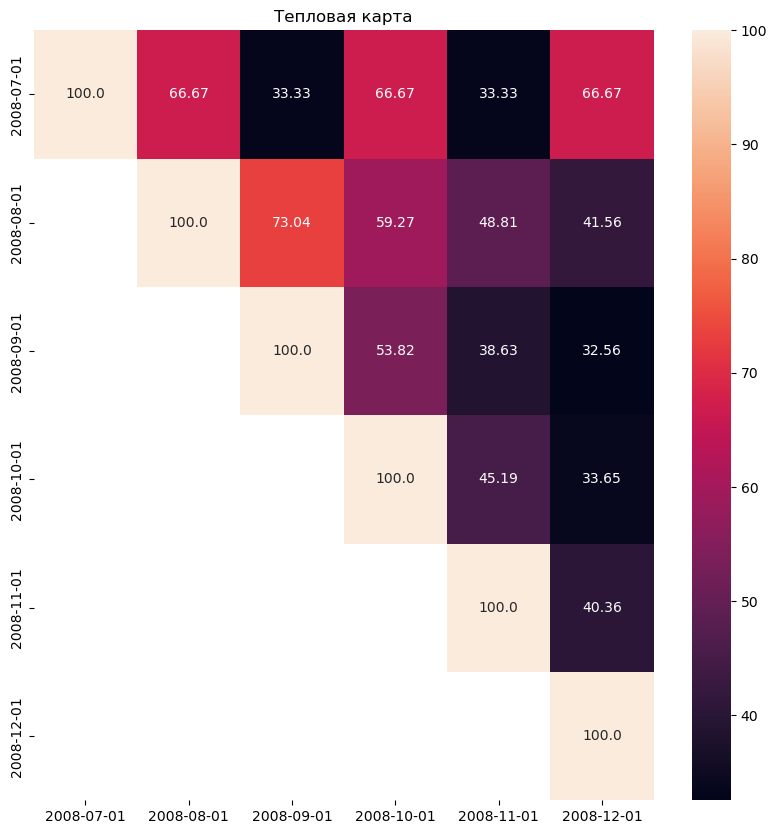

In [23]:
# создаём сводную таблицу с результатами
retention = retention_rate.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

**Вывод**

- В когорте пользователей, пришедших в ноябре 2008 г., наблюдается самое низкое значение Retention Rate за первый месяц.
- Среди пользователей когорты 1 июля 2008 г. коэффициент удержания первого месяца больше 60%, второго месяца - 33%, третьего месяца - больше 60% и т.д. Поскольку официальная дата запуска платформы указана в августе, то, возможно, в июле платформу запускали в качестве тестовой версии, где случались сбои с постами.
- Среди пользователей когорты 1 августе 2008 г. наблюдается самый высокий уровень удержания на протяжении всего периода. Поскольку платформа стартовала и получила широкую известность в августе 2008 г., то многие программисты стали ей регулярно пользоваться, поскольку бесплатных аналогов данной платформы не было. Платформа закрыла потребительскую боль в поиске информации, поэтому, возможно, что из-за этого уровень удержания был высокий. 

### Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [24]:
# напишите запрос
query = '''
WITH mp AS (SELECT EXTRACT(MONTH FROM creation_date::date) AS creation_month,
                    COUNT(DISTINCT id) AS posts_count    
                    FROM stackoverflow.posts
                    WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
                    GROUP BY creation_month)

SELECT *,
       ROUND(((posts_count::numeric / LAG(posts_count) OVER (ORDER BY creation_month)) - 1) * 100, 2) AS percentage
FROM mp;
'''

# выполните запрос
mp = pd.read_sql_query(query, con = engine) 

In [25]:
print(mp)

   creation_month  posts_count  percentage
0             9.0        70371         NaN
1            10.0        63102      -10.33
2            11.0        46975      -25.56
3            12.0        44592       -5.07


Постройте круговую диаграмму с количеством постов по месяцам.

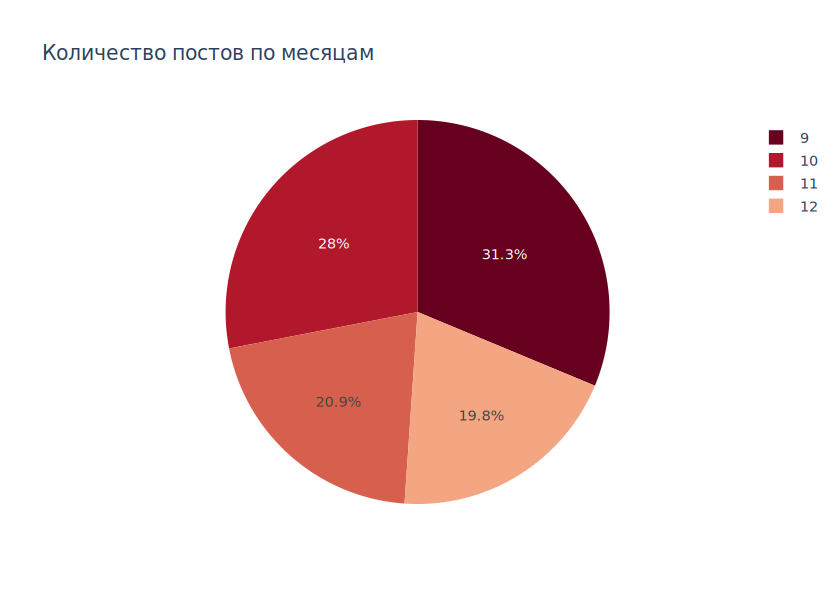

In [26]:
# постройте круговую диаграмму с количеством постов по месяцам

fig = px.pie(mp, values=mp['posts_count'], names=mp['creation_month'], \
             color_discrete_sequence=px.colors.sequential.RdBu, title = 'Количество постов по месяцам')
fig.show()

**Вывод**

Больше всего постов было опубликовано в сентябре 2008 г., а меньше всего - в декабре. 
Скорее всего, большое количество постов в сентябре обусловлено тем, что многие студенты начинают учиться и тем самым задают больше вопросов на платформе.

### Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [27]:
# напишите запрос
query = '''
WITH pt AS (SELECT DISTINCT user_id,
                   COUNT(id) AS sum_post
            FROM stackoverflow.posts
            GROUP BY user_id
            ORDER BY sum_post DESC
            LIMIT 1),
       
dt AS (SELECT p.user_id,
              p.creation_date,
              EXTRACT('week' FROM p.creation_date::date) AS week_creation
       FROM stackoverflow.posts AS p
       JOIN pt ON pt.user_id = p.user_id
       WHERE DATE_TRUNC('month', p.creation_date::date) = '2008-10-01')

SELECT DISTINCT dt.week_creation,
       MAX(creation_date) OVER (PARTITION BY week_creation) AS creation_date
FROM dt
ORDER BY creation_date;
'''

# выполните запрос
result = pd.read_sql_query(query, con = engine) 

In [28]:
print(result)

   week_creation       creation_date
0           40.0 2008-10-05 09:00:58
1           41.0 2008-10-12 21:22:23
2           42.0 2008-10-19 06:49:30
3           43.0 2008-10-26 21:44:36
4           44.0 2008-10-31 22:16:01


## Вывод

Данные: База данных StackOverflow за 2008 г.

Выводы:

- Большое количество постов было опубликовано в сентябре, а наибольшее количество просмотров постов также наблюдалось в сентябре и октябре. Такие результаты могут быть связаны с началом учебного года в колледжах и университетах, поэтому студенты чаще начинают задавать вопросы. Наименьшее количество просмотров постов - в июле, что также может быть связано с каникулами в учебных заведениях и с отпусками специалистов.
- Самые активные пользователи, которые давали больше всего ответов, имеют сокращенные имена: Chris, Dan, Greg.
- В базе данных наблюдаются аномалии с рекордно низким количеством постов в августе, что может быть связано с необязательной регистрацией на платформе или сбоями в формировании даты создания постов.
- Наблюдаются аномалии в показателе удержания пользователей в июле 2008 г., что также может быть связано с некорректным учетом постов.